In [2]:
# 查看当前挂载的数据集目录, 该目录下的变更重启环境后会自动还原
# View dataset directory. This directory will be recovered automatically after resetting environment. 
!ls /home/aistudio/data

data7876


**解压手势**0-9数据集到data/aistudio/images/gesture目录下

In [27]:
import zipfile
f = zipfile.ZipFile("/home/aistudio/data/data7876/Dataset.zip",'r')
for file in f.namelist():
    f.extract(file,"/home/aistudio/images/gesture")

![](https://ai-studio-static-online.cdn.bcebos.com/8b500211861043d0a8e96caeab659ab989ecae0d569543f6bd73646f1b11947c)

**Step1：准备数据。**

(1)数据集介绍 自定义数据集。包含了0-9数字的手势数据集共2265张。按照6:1的比例进行划分，6/7用于训练，1/7用于测试。 自定义的数据集，首先要生成图像列表，把自定的图像分为测试集和训练集，并带有标签。下面的程序可以单独运行，只要把一个大类的文件夹路径传进去就可以了,该程序会把里面的每个小类别都迭代,生成固定格式的列表.比如我们把手势的根目录传进去../images/gesture。最后会在指定目录下面生成三个文件，readme.json、trainer.list和test.list.

In [28]:
import os
import json

# 设置要生成文件的路径
data_root_path = '/home/aistudio/images/gesture'
# 所有类别的信息
class_detail = []
# 获取所有类别保存的文件夹名称
class_dirs = os.listdir(data_root_path)
# 类别标签
class_label = 0
# 获取总类别的名称
father_paths = data_root_path.split('/')    #['', 'home', 'aistudio', 'images', 'gesture']
while True:
    if father_paths[father_paths.__len__() - 1] == '':
        del father_paths[father_paths.__len__() - 1]
    else:
        break
father_path = father_paths[father_paths.__len__() - 1]
# 把生产的数据列表都放在自己的总类别文件夹中
data_list_path = '/home/aistudio/%s/' % father_path
# 如果不存在这个文件夹,就创建
isexist = os.path.exists(data_list_path)
if not isexist:
    os.makedirs(data_list_path)
# 清空原来的数据
with open(data_list_path + "test.list", 'w') as f:
    pass
with open(data_list_path + "trainer.list", 'w') as f:
    pass
# 总的图像数量
all_class_images = 0
# 读取每个类别
for class_dir in class_dirs:
    # 每个类别的信息
    class_detail_list = {}
    test_sum = 0
    trainer_sum = 0
    # 统计每个类别有多少张图片
    class_sum = 0
    # 获取类别路径
    path = data_root_path + "/" + class_dir
    # 获取所有图片
    img_paths = os.listdir(path)

    for img_path in img_paths:                                  # 遍历文件夹下的每个图片
        name_path = path + '/' + img_path                       # 每张图片的路径
        if class_sum % 7 == 0:                                  # 每7张图片取一个做测试数据
            test_sum += 1                                       #test_sum测试数据的数目
            with open(data_list_path + "test.list", 'a') as f:
                f.write(name_path + "\t%d" % class_label + "\n") #class_label 标签：0,1,2
        else:
            trainer_sum += 1                                    #trainer_sum测试数据的数目
            with open(data_list_path + "trainer.list", 'a') as f:
                f.write(name_path + "\t%d" % class_label + "\n")#class_label 标签：0,1,2
        class_sum += 1                                          #每类图片的数目
        all_class_images += 1                                   #所有类图片的数目

    # 说明的json文件的class_detail数据
    class_detail_list['class_name'] = class_dir             #类别名称
    class_detail_list['class_label'] = class_label          #类别标签，0,1,2
    class_detail_list['class_test_images'] = test_sum       #该类数据的测试集数目
    class_detail_list['class_trainer_images'] = trainer_sum #该类数据的训练集数目
    class_detail.append(class_detail_list)         
    class_label += 1                                            #class_label 标签：0,1,2
# 获取类别数量
all_class_sum = class_dirs.__len__()
# 说明的json文件信息
readjson = {}
readjson['all_class_name'] = father_path                  #文件父目录
readjson['all_class_sum'] = all_class_sum                #
readjson['all_class_images'] = all_class_images
readjson['class_detail'] = class_detail
jsons = json.dumps(readjson, sort_keys=True, indent=4, separators=(',', ': '))
with open(data_list_path + "readme.json",'w') as f:
    f.write(jsons)
print ('生成数据列表完成！')

生成数据列表完成！


查看创建的json文件，用于预测标签列表的设置，列表中标签的顺序要和下面的一一对应，要写成：label_list

In [1]:
cat /home/aistudio/gesture/readme.json

{
    "all_class_images": 2265,
    "all_class_name": "gesture",
    "all_class_sum": 10,
    "class_detail": [
        {
            "class_label": 0,
            "class_name": "4",
            "class_test_images": 36,
            "class_trainer_images": 212
        },
        {
            "class_label": 1,
            "class_name": "1",
            "class_test_images": 33,
            "class_trainer_images": 198
        },
        {
            "class_label": 2,
            "class_name": "8",
            "class_test_images": 32,
            "class_trainer_images": 192
        },
        {
            "class_label": 3,
            "class_name": "7",
            "class_test_images": 31,
            "class_trainer_images": 184
        },
        {
            "class_label": 4,
            "class_name": "5",
            "class_test_images": 32,
            "class_trainer_images": 192
        },
        {
            "class_label": 5,
            "class_name": "0",
            "class_tes

In [2]:
# 定义训练的mapper
# train_mapper函数的作用是用来对训练集的图像进行处理修剪和数组变换，返回img数组和标签 
# sample是一个python元组，里面保存着图片的地址和标签。 ('../images/gesture/4/IMG_0119.png', 4)
def train_mapper(sample):
    img, label = sample
    # 进行图片的读取，由于数据集的像素维度各不相同，需要进一步处理对图像进行变换
    img = paddle.dataset.image.load_image(img)       
    #进行了简单的图像变换，这里对图像进行crop修剪操作，输出img的维度为(3, 100, 100)
    img = paddle.dataset.image.simple_transform(im=img,          #输入图片是HWC   
                                                resize_size=100, # 剪裁图片
                                                crop_size=100, 
                                                is_color=True,  #彩色图像
                                                is_train=True)
    #将img数组进行进行归一化处理，得到0到1之间的数值
    img= img.flatten().astype('float32')/255.0
    return img, label
# 对自定义数据集创建训练集train的reader
def train_r(train_list, buffered_size=1024):
    def reader():
        with open(train_list, 'r') as f:
            # 将train.list里面的标签和图片的地址方法一个list列表里面，中间用\t隔开'
            #../images/gesture/gesture8/IMG_4157.png\t0'
            lines = [line.strip() for line in f]
            for line in lines:
                # 图像的路径和标签是以\t来分割的,所以我们在生成这个列表的时候,使用\t就可以了
                img_path, lab = line.strip().split('\t')
                yield img_path, int(lab) 
    # 创建自定义数据训练集的train_reader
    return paddle.reader.xmap_readers(train_mapper, reader,cpu_count(), buffered_size)

# sample是一个python元组，里面保存着图片的地址和标签。 ('../images/gesture/gesture8/IMG_4157.png', 0)
def test_mapper(sample):
    img, label = sample
    img = paddle.dataset.image.load_image(img)
    img = paddle.dataset.image.simple_transform(im=img, resize_size=100, crop_size=100, is_color=True, is_train=False)
    img= img.flatten().astype('float32')/255.0
    return img, label

# 对自定义数据集创建测试集test的reader
def test_r(test_list, buffered_size=1024):
    def reader():
        with open(test_list, 'r') as f:
            lines = [line.strip() for line in f]
            for line in lines:
                #图像的路径和标签是以\t来分割的,所以我们在生成这个列表的时候,使用\t就可以了
                img_path, lab = line.strip().split('\t')
                yield img_path, int(lab)

    return paddle.reader.xmap_readers(test_mapper, reader,cpu_count(), buffered_size)

In [3]:
import paddle
import paddle.fluid as fluid
import numpy as np 
import sys  
from multiprocessing import cpu_count  
import matplotlib.pyplot as plt  
import os  

(2)train_reader和test_reader

train_reader和test_reader分别用于获取训练集和测试集 paddle.reader.shuffle()表示每次缓存BUF_SIZE个数据项，并进行打乱 paddle.batch()表示每BATCH_SIZE组成一个batch

自定义数据集需要先定义自己的reader，把图像数据处理一下，并输出图片的数组和标签。

In [4]:
BATCH_SIZE = 32
# 把图片数据生成reader
trainer_reader = train_r(train_list="/home/aistudio/gesture/trainer.list")
train_reader = paddle.batch(
    paddle.reader.shuffle(
        reader=trainer_reader,buf_size=320),
    batch_size=BATCH_SIZE)

tester_reader = test_r(test_list="/home/aistudio/gesture/test.list")
test_reader = paddle.batch(
      tester_reader,batch_size=BATCH_SIZE)

（3）打印看下数据。PaddlePaddle接口提供的数据已经经过了归一化、居中等处理 打印一下，观察一下自定义的数据集

In [9]:
# train_data = paddle.batch(trainer_reader,
#                             batch_size=3)
# sampledata=next(train_data())
# print(sampledata)

![](https://ai-studio-static-online.cdn.bcebos.com/350bf49983a74df5aaf1045f538f4b004ae23d7778044b5f9929b1e7751988d6)

**Step2.网络配置**

（1）搭建网络

配置网络主要是用来组建一个Program，主要包括三个部分：1.网络模型2.损失函数3.优化函数

搭建的CNN网络

![](https://ai-studio-static-online.cdn.bcebos.com/4875645d16a448f48d7afdf4de9647f4e1df74677d86454382e6f1ae58a72457)

In [69]:
def convolutional_neural_network(image, type_size):
    # 第一个卷积--池化层
    conv_pool_1 = fluid.nets.simple_img_conv_pool(input=image,# 输入图像
                                                      filter_size=3,# 滤波器的大小
                                                      num_filters=32,# filter 的数量。它与输出的通道相同
                                                      pool_size=2,# 池化层大小2*2
                                                      pool_stride=2,# 池化层步长
                                                      act='relu') # 激活类型
    
    # Dropout主要作用是减少过拟合，随机让某些权重不更新  
    # Dropout是一种正则化技术，通过在训练过程中阻止神经元节点间的联合适应性来减少过拟合。
    # 根据给定的丢弃概率dropout随机将一些神经元输出设置为0，其他的仍保持不变。
    drop = fluid.layers.dropout(x=conv_pool_1, dropout_prob=0.1)
    
    # 第二个卷积--池化层
    conv_pool_2 = fluid.nets.simple_img_conv_pool(input=drop,
                                                      filter_size=3,
                                                      num_filters=64,
                                                      pool_size=2,
                                                      pool_stride=2,
                                                      act='relu')
    # 减少过拟合，随机让某些权重不更新                                                   
    drop = fluid.layers.dropout(x=conv_pool_2, dropout_prob=0.1)
    
    # 第三个卷积--池化层
    conv_pool_3 = fluid.nets.simple_img_conv_pool(input=drop,
                                                      filter_size=3,
                                                      num_filters=64,
                                                      pool_size=2,
                                                      pool_stride=2,
                                                      act='relu')
    # 减少过拟合，随机让某些权重不更新                                                   
    drop = fluid.layers.dropout(x=conv_pool_3, dropout_prob=0.1)
    
    # 全连接层
    fc = fluid.layers.fc(input=drop, size=512, act='relu')
    # 减少过拟合，随机让某些权重不更新                                                   
    drop =  fluid.layers.dropout(x=fc, dropout_prob=0.0)                                                   
    # 输出层 以softmax为激活函数的全连接输出层，输出层的大小为图像类别type_size个数
    predict = fluid.layers.fc(input=drop,size=type_size,act='softmax')
    
    return predict

搭建VGG网络

1.首先定义了一组卷积网络，即conv_block。卷积核大小为3x3，池化窗口大小为2x2，窗口滑动大小为2，groups决定每组VGG模块是几次连续的卷积操作，dropouts指定Dropout操作的概率。所使用的img_conv_group是在paddle.networks中预定义的模块，由若干组 Conv->BN->ReLu->Dropout 和 一组 Pooling 组成。

2.五组卷积操作，即 5个conv_block。 第一、二组采用两次连续的卷积操作。第三、四、五组采用三次连续的卷积操作。每组最后一个卷积后面Dropout概率为0.1

3.最后接三层512维的全连接。

4.通过上面VGG网络提取高层特征，然后经过全连接层映射到类别维度大小的向量，再通过Softmax归一化得到每个类别的概率，也可称作分类器。 

![](https://ai-studio-static-online.cdn.bcebos.com/054acc1cfd304b29b66e1571c48848f5c32668fd4cf54da9bd3f279a02cf1c54)

In [14]:
def vgg_bn_drop(image):   
    def conv_block(ipt, num_filter, groups, dropouts):#从第二层开始，每一层接受上一层的输出，
    #第二个参数根据VGG结构定义每一层输出的维度， 
    # 第三个参数定义连续卷积的次数，第四个参数定义dropout的概率
        return fluid.nets.img_conv_group( 
            input=ipt, # 具有[N，C，H，W]格式的输入图像 
            pool_size=2, 
            pool_stride=2, 
            conv_num_filter=[num_filter] * groups, # 过滤器个数 
            conv_filter_size=3, # 过滤器大小 
            conv_act='relu', 
            conv_with_batchnorm=True, # 表示在 Conv2d Layer 之后是否使用 BatchNorm 
            conv_batchnorm_drop_rate=dropouts,# 表示 BatchNorm 之后的 Dropout Layer 的丢弃概率 
            pool_type='max') # 最大池化 
 
    conv1 = conv_block(image, 64, 2, [0.0, 0]) 
    conv2 = conv_block(conv1, 128, 2, [0.0, 0]) 
    conv3 = conv_block(conv2, 256, 3, [0.0, 0.0, 0]) 
    conv4 = conv_block(conv3, 512, 3, [0.0, 0.0, 0]) 
    conv5 = conv_block(conv4, 512, 3, [0.0, 0.0, 0]) 
    # 根据网络结构，后面需要做三层全连接操作，定义如下： 
    drop = fluid.layers.dropout(x=conv5, dropout_prob=0.3) 
    fc1 = fluid.layers.fc(input=drop, size=512, act=None) 
    bn = fluid.layers.batch_norm(input=fc1, act='relu') 
    drop2 = fluid.layers.dropout(x=bn, dropout_prob=0.3) 
    fc2 = fluid.layers.fc(input=drop2, size=512, act=None) 
    predict = fluid.layers.fc(input=fc2, size=10, act='softmax') 
    return predict 

（2）定义数据层

image 和 label 是通过 fluid.layers.data 创建的两个输入数据层。其中 image 是 [3, 100, 100] 维度的浮点数据; label 是 [1] 维度的整数数据。

这里需要注意的是: Fluid中默认使用 -1 表示 batch size 维度，默认情况下会在 shape 的第一个维度添加 -1 。 所以 上段代码中， 我们可以接受将一个 [-1, 3, 100, 100] 的numpy array传给 image 。Fluid中用来做类别标签的数据类型是 int64，并且标签从0开始。

In [15]:
image = fluid.layers.data(name='image', shape=[3, 100, 100], dtype='float32')#[3, 100, 100]，表示为三通道，100*100的RGB图image = fluid.layers.data(name='image', shape=[3, 100, 100], dtype='float32')#[3, 100, 100]，表示为三通道，100*100的RGB图
label = fluid.layers.data(name='label', shape=[1], dtype='int64')
print('image_shape:',image.shape)
print('label_shape:',label.shape)

image_shape: (-1, 3, 100, 100)
label_shape: (-1, 1)


（3）获取网络的输出结果predict


In [16]:
# ##### 获取分类器
#predict= convolutional_neural_network(image,10)
predict =vgg_bn_drop(image)

（4）定义损失函数和准确率

这次使用的是交叉熵损失函数，该函数在分类任务上比较常用。

定义了一个损失函数之后，还有对它求平均值，因为定义的是一个Batch的损失值。

同时我们还可以定义一个准确率函数，这个可以在我们训练的时候输出分类的准确率。

In [17]:
# 获取损失函数和准确率 
cost = fluid.layers.cross_entropy(input=predict, label=label) 
# 计算cost中所有元素的平均值 
avg_cost = fluid.layers.mean(cost) 
#计算准确率 
accuracy = fluid.layers.accuracy(input=predict, label=label) 

（5）定义优化方法

接着是定义优化方法，这次我们使用的是Adam优化方法，同时指定学习率为0.001。

In [18]:
# 定义优化方法 
optimizer = fluid.optimizer.Adam(learning_rate=0.001)    # Adam是一阶基于梯度下降的算法，基于自适应低阶矩估计该函数实现了自适应矩估计优化器 
optimizer.minimize(avg_cost)                             # 取局部最优化的平均损失 
print(type(accuracy)) 

<class 'paddle.fluid.framework.Variable'>


在上述模型配置完毕后，得到两个fluid.Program：fluid.default_startup_program() 与fluid.default_main_program() 配置完毕了。

参数初始化操作会被写入fluid.default_startup_program()

fluid.default_main_program()用于获取默认或全局main program(主程序)。该主程序用于训练和测试模型。fluid.layers 中的所有layer函数可以向 default_main_program 中添加算子和变量。default_main_program 是fluid的许多编程接口（API）的Program参数的缺省值。例如,当用户program没有传入的时候， Executor.run() 会默认执行 default_main_program 。

![](https://ai-studio-static-online.cdn.bcebos.com/58db9ccd915943a692e6d87ad77fbf637b525906c0f44644b98c810eb8f7809a)

**Step3.模型训练 and Step4.模型评估**

（1）创建Executor

首先定义运算场所 fluid.CPUPlace()和 fluid.CUDAPlace(0)分别表示运算场所为CPU和GPU

Executor:接收传入的program，通过run()方法运行program。

训练分为三步：第一步配置好训练的环境，第二步用训练集进行训练，并用验证集对训练进行评估，不断优化，第三步保存好训练的模型

In [19]:
# 使用CPU或者GPU进行训练
place = fluid.CPUPlace()
#place = fluid.CUDAPlace(0)
# 创建一个executor
exe = fluid.Executor(place)
# 对program进行参数初始化1.网络模型2.损失函数3.优化函数
exe.run(fluid.default_startup_program())

[]

（2）定义数据映射器

DataFeeder负责将数据提供器（train_reader,test_reader）返回的数据转成一种特殊的数据结构，使其可以输入到Executor中。

feed_list设置向模型输入的向变量表或者变量表名

In [20]:
# 定义输入数据的维度,DataFeeder 负责将reader(读取器)返回的数据转成一种特殊的数据结构，使它们可以输入到 Executor
feeder = fluid.DataFeeder(feed_list=[image, label], place=place)#定义输入数据的维度，第一个是图片数据，第二个是图片对应的标签。

(3)绘制模型训练曲线

In [21]:
all_train_iter=0
all_train_iters=[]
all_train_costs=[]
all_train_accs=[]

def draw_train_process(title,iters,costs,accs,label_cost,lable_acc):
    plt.title(title, fontsize=27)
    plt.xlabel("iter", fontsize=22)
    plt.ylabel("cost/acc", fontsize=22)
    plt.plot(iters, costs,color='red',label=label_cost) 
    plt.plot(iters, accs,color='green',label=lable_acc) 
    plt.legend()
    plt.grid()
    plt.show()

（4）训练并保存模型

Executor接收传入的program,并根据feed map(输入映射表)和fetch_list(结果获取表) 向program中添加feed operators(数据输入算子)和fetch operators（结果获取算子)。

feed map为该program提供输入数据。fetch_list提供program训练结束后用户预期的变量。

这次训练1000个Pass。每一个Pass训练结束之后，再使用验证集进行验证，并求出相应的损失值Cost和准确率acc。

In [ ]:
# # VGG16训练
# EPOCH_NUM =50
# print('开始训练...')
# model_save_dir = "/home/aistudio/model_vgg16"

# for pass_id in range(EPOCH_NUM):
#     # 进行训练
#     train_cost = 0
#     for batch_id, data in enumerate(train_reader()):            #遍历train_reader的迭代器，并为数据加上索引batch_id
#         train_cost, train_acc = exe.run(
#             program=fluid.default_main_program(),               #运行主程序
#             feed=feeder.feed(data),                             #喂入一个batch的数据
#             fetch_list=[avg_cost, accuracy])                    #fetch均方误差和准确率
        
#         all_train_iter=all_train_iter+BATCH_SIZE
#         all_train_iters.append(all_train_iter)
#         all_train_costs.append(train_cost[0])
#         all_train_accs.append(train_acc[0])
       
       
#         if batch_id % 10 == 0:                                               #每10次batch打印一次训练、误差、准确率
#             print("\nPass %d, batch %d, Cost %f, Acc %f" % 
#             (pass_id, batch_id, train_cost[0], train_acc[0]))
#     # 开始测试
#     test_accs = []                                                            #测试的损失值
#     test_costs = []                                                           #测试的准确率
#     # 每训练一轮 进行一次测试
#     for batch_id, data in enumerate(test_reader()):                           # 遍历test_reader
#          test_cost, test_acc = exe.run(program=fluid.default_main_program(),  # #运行测试主程序
#                                       feed=feeder.feed(data),                #喂入一个batch的数据
#                                       fetch_list=[avg_cost, accuracy])       #fetch均方误差、准确率
#          test_accs.append(test_acc[0])                                        #记录每个batch的误差
#          test_costs.append(test_cost[0])                                      #记录每个batch的准确率

#   # 求测试结果的平均值
#     test_cost = (sum(test_costs) / len(test_costs))                           # 每轮的平均误差
#     test_acc = (sum(test_accs) / len(test_accs))                              # 每轮的平均准确率
#     print('Test:%d, Cost:%0.5f, ACC:%0.5f' % (pass_id, test_cost, test_acc))

    
#     # 如果保存路径不存在就创建
# if not os.path.exists(model_save_dir):
#         os.makedirs(model_save_dir)
#     # print ('save models to %s' % (model_save_dir))
#     # 保存训练的模型，executor 把所有相关参数保存到 dirname 中
# fluid.io.save_inference_model(dirname=model_save_dir, 
#                                     feeded_var_names=["image"],
#                                     target_vars=[predict],
#                                     executor=exe)
                                    
# draw_train_process("training",all_train_iters,all_train_costs,all_train_accs,"trainning cost","trainning acc")

# print('训练模型保存完成！')
# print ('save models to %s' % (model_save_dir))

开始训练...

Pass 0, batch 0, Cost 2.798699, Acc 0.031250


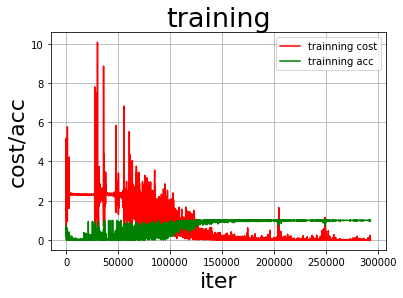

训练模型保存完成！
save models to /home/aistudio/model_cnn


In [78]:
5层简单的CNN
EPOCH_NUM =150
print('开始训练...')
model_save_dir = "/home/aistudio/model_cnn"

for pass_id in range(EPOCH_NUM):
    # 进行训练
    train_cost = 0
    for batch_id, data in enumerate(train_reader()):            #遍历train_reader的迭代器，并为数据加上索引batch_id
        train_cost, train_acc = exe.run(
            program=fluid.default_main_program(),               #运行主程序
            feed=feeder.feed(data),                             #喂入一个batch的数据
            fetch_list=[avg_cost, accuracy])                    #fetch均方误差和准确率
        
        all_train_iter=all_train_iter+BATCH_SIZE
        all_train_iters.append(all_train_iter)
        all_train_costs.append(train_cost[0])
        all_train_accs.append(train_acc[0])
       
       
        if batch_id % 10 == 0:                                               #每10次batch打印一次训练、误差、准确率
            print("\nPass %d, batch %d, Cost %f, Acc %f" % 
            (pass_id, batch_id, train_cost[0], train_acc[0]))
    # 开始测试
    test_accs = []                                                            #测试的损失值
    test_costs = []                                                           #测试的准确率
    # 每训练一轮 进行一次测试
    for batch_id, data in enumerate(test_reader()):                           # 遍历test_reader
         test_cost, test_acc = exe.run(program=fluid.default_main_program(),  # #运行测试主程序
                                      feed=feeder.feed(data),                #喂入一个batch的数据
                                      fetch_list=[avg_cost, accuracy])       #fetch均方误差、准确率
         test_accs.append(test_acc[0])                                        #记录每个batch的误差
         test_costs.append(test_cost[0])                                      #记录每个batch的准确率

  # 求测试结果的平均值
    test_cost = (sum(test_costs) / len(test_costs))                           # 每轮的平均误差
    test_acc = (sum(test_accs) / len(test_accs))                              # 每轮的平均准确率
    print('Test:%d, Cost:%0.5f, ACC:%0.5f' % (pass_id, test_cost, test_acc))

    
    # 如果保存路径不存在就创建
if not os.path.exists(model_save_dir):
        os.makedirs(model_save_dir)
    # print ('save models to %s' % (model_save_dir))
    # 保存训练的模型，executor 把所有相关参数保存到 dirname 中
fluid.io.save_inference_model(dirname=model_save_dir, 
                                    feeded_var_names=["image"],
                                    target_vars=[predict],
                                    executor=exe)
                                    
draw_train_process("training",all_train_iters,all_train_costs,all_train_accs,"trainning cost","trainning acc")

print('训练模型保存完成！')
print ('save models to %s' % (model_save_dir))

![](https://ai-studio-static-online.cdn.bcebos.com/6c3d0f0621e54f6289e4a9e40d5e2e4ce7d9f5f6dbe140e485c5fba77d111e8e)


**Step5.模型预测**

下面是预测程序，直接单独运行In[*]就可以。

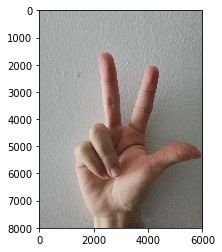

分类推测概率分布为：
[array([[7.2194771e-11, 3.2120552e-02, 1.3858469e-08, 3.5682032e-07,
        3.4472926e-08, 1.6060588e-13, 9.6522129e-01, 2.5314530e-03,
        3.7137357e-07, 1.2590393e-04]], dtype=float32)]
手势预测的结果: 手势3


In [2]:
# coding:utf-8
import paddle.fluid as fluid
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import paddle
import os

def file_name(file_dir):
    File_Name=[]
    for files in os.listdir(file_dir):
        if os.path.splitext(files)[1] == '.jpg'or os.path.splitext(files)[1] == '.JPG' :
            File_Name.append(files)
    return File_Name

# 使用CPU进行预测环境place
place = fluid.CPUPlace()
# 定义一个executor
infer_exe = fluid.Executor(place)
inference_scope = fluid.core.Scope()#要想运行一个网络，需要指明它运行所在的域，确切的说： exe.Run(&scope) 

#选择保存训练模型的位置
params_dirname ='/home/aistudio/model_cnn'

# （1）图片预处理
def load_image(path):
    img = Image.open(path)
    #img = img.resize((100,100),Image.ANTIALIAS) 
    plt.imshow(img)
    plt.show()    #显示图像
    img = paddle.dataset.image.load_and_transform(path,100,100, False).astype('float32')#裁剪到100x100像素
    img = img / 255.0
    return img
infer_imgs = []

#获取测试的图片的路径
jpglist = file_name('/home/aistudio/testimages')
jpgstr = ''.join(jpglist)
filepath = '/home/aistudio/testimages/' + jpgstr
# 选择不同的图片进行预测
infer_imgs.append(load_image(filepath))
infer_imgs = np.array(infer_imgs)

#fluid.scope_guard修改全局/默认作用域（scope）, 运行时中的所有变量都将分配给新的scope
with fluid.scope_guard(inference_scope):
    
     #获取训练好的模型
    #从指定目录中加载 推理model(inference model)
    [inference_program,# 预测用的program
     feed_target_names,# 是一个str列表，它包含需要在推理 Program 中提供数据的变量的名称。
     fetch_targets] = fluid.io.load_inference_model(params_dirname, infer_exe)
    # 开始预测
    results = infer_exe.run(
        inference_program,                      #运行预测程序
        feed={feed_target_names[0]: infer_imgs},#喂入要预测的数据
        fetch_list=fetch_targets)               #得到推测结果
    print('分类推测概率分布为：')  
    print(results)   #打印分类推测结果
     # 训练数据的标签
    label_list = ["手势4","手势1","手势8","手势7","手势5","手势0","手势3","手势2","手势6","手势9"]
    #print(label_list)
    #print('推断在lable中索引为:',np.argmax(results[0]))
    print("手势预测的结果: %s" % label_list[np.argmax(results[0])])

In [80]:
# 查看工作区文件, 该目录下的变更将会持久保存. 请及时清理不必要的文件, 避免加载过慢.
# View personal work directory. All changes under this directory will be kept even after reset. Please clean unnecessary files in time to speed up environment loading.
!ls /home/aistudio/work